# Classifaing both Alzheimer's and Brain Tumor 

I will build step by step model to evaluate the MRI Images and find Alzheimer's disease severity, type of Brain tumor on no disease

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

import functions

# For reproducibility
np.random.seed(18)

In [29]:
# Set image size
image_size = 240

### Functions

In [62]:
def load_img_from_dir_cat(path):
    '''
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            continue
        else:
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    # target_size automatically resizes each img on import
                    image = load_img(f'{path}/{label}/{image_file}', color_mode = 'grayscale', target_size=(image_size, image_size))
                    image = img_to_array(image) / 255
                    X.append(image)
                    if num_label == 3:
                        num_label = 2
                    y.append(num_label) 
                    # For training the model
    if 'train' in path:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        # Change for TensorFlow models
        X_train = np.array(X_train, dtype='float32')
        X_val = np.array(X_val, dtype='float32')

        y_train = to_categorical(y_train, num_classes=3, dtype='float32')
        y_val = to_categorical(y_val, num_classes=3, dtype='float32')

        return X_train, X_val, y_train, y_val
    # For testing
    else:
        X_test = np.array(X, dtype='float32')
        y_test = to_categorical(y, num_classes=3, dtype='float32')
        return X_test, y_test

In [33]:
def load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Change each image and append to X and y
        for image_file in listdir(f'{path}/{label}'):
             if '.jpg' in image_file:
                # target_size automatically resizes each img on import
                image = load_img(f'{path}/{label}/{image_file}', color_mode = 'grayscale', target_size=(image_size, image_size))
                image = img_to_array(image) / 255
                X.append(image)
                if label in ('NonDemented', 'no_tumor'):
                    y.append(0)
                else:
                    y.append(1)
    return X, y

In [34]:
def al_bt_load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            # Change each image and append to X and y
            for image_file in os.listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    # target_size automatically resizes each img on import
                    image = load_img(f'{path}/{label}/{image_file}', color_mode = 'grayscale', target_size=(image_size, image_size))
                    image = img_to_array(image) / 255
                    X.append(image)
                    if 'alzheimer' in path:
                        y.append(0)
                    else:
                        y.append(1)
    return X, y

In [35]:
def combine_images_from_two_path_binary(path1, path2, function = load_img_from_dir_binary):
    X_1, y_1 = function(path1)
    X_2, y_2 = function(path2)
    
    X = X_1 + X_2
    y = y_1 + y_2
    if 'train' in path1:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        X_train = np.array(X_train, dtype='float32')
        X_val = np.array(X_val, dtype='float32')
        y_train = np.array(y_train, dtype='float32')
        y_val = np.array(y_val, dtype='float32')
        return X_train, X_val, y_train, y_val
    else:
        X_test = np.array(X, dtype='float32')
        y_test = np.array(y, dtype='float32')
        return X_test, y_test

In [36]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

In [37]:
# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

## Make Binary data Disease - No disease
Combine datasets and make binary data - disease - 1, no disease - 0

In [103]:
X_train, X_val, y_train, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train)

In [104]:
X_train.shape, y_train.shape

((5993, 240, 240, 1), (5993,))

In [105]:
X_test, y_test = combine_images_from_two_path_binary(al_path_test, bt_path_test)

In [108]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model.add(Conv2D(128, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model.add(Conv2D(256, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model.add(Conv2D(512, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.005))) 
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es, reduce_lr])

Epoch 1/50
188/188 [==============================] - 356s 2s/step - loss: 0.9466 - accuracy: 0.6302 - val_loss: 0.6727 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 339s 2s/step - loss: 0.6639 - accuracy: 0.6302 - val_loss: 0.6602 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 492s 3s/step - loss: 0.6601 - accuracy: 0.6302 - val_loss: 0.6598 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 499s 3s/step - loss: 0.6598 - accuracy: 0.6302 - val_loss: 0.6591 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 495s 3s/step - loss: 0.6594 - accuracy: 0.6302 - val_loss: 0.6590 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 485s 3s/step - loss: 0.6589 - accuracy: 0.6302 - val_loss: 0.6598 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - 491s 3s/st

KeyboardInterrupt: 

Accuracy_score: 0.5547 



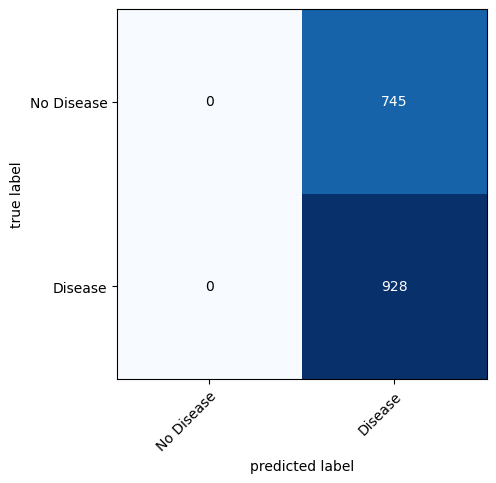

In [107]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [41]:
model = Sequential()


model.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es])

Epoch 1/50
188/188 [==============================] - 765s 4s/step - loss: 0.5800 - accuracy: 0.7018 - val_loss: 0.4960 - val_accuracy: 0.7142
Epoch 2/50
188/188 [==============================] - 797s 4s/step - loss: 0.3850 - accuracy: 0.8158 - val_loss: 0.3453 - val_accuracy: 0.8313
Epoch 3/50
188/188 [==============================] - 758s 4s/step - loss: 0.2264 - accuracy: 0.9067 - val_loss: 0.2538 - val_accuracy: 0.9009
Epoch 4/50
188/188 [==============================] - 800s 4s/step - loss: 0.1276 - accuracy: 0.9549 - val_loss: 0.1936 - val_accuracy: 0.9339
Epoch 5/50
188/188 [==============================] - 771s 4s/step - loss: 0.0732 - accuracy: 0.9740 - val_loss: 0.1655 - val_accuracy: 0.9605
Epoch 6/50
188/188 [==============================] - 773s 4s/step - loss: 0.0366 - accuracy: 0.9900 - val_loss: 0.1639 - val_accuracy: 0.9635
Epoch 7/50
188/188 [==============================] - 765s 4s/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.2025 - val_accuracy: 0.9575

In [49]:
model.save('../models/model_d_nd.hdf5')

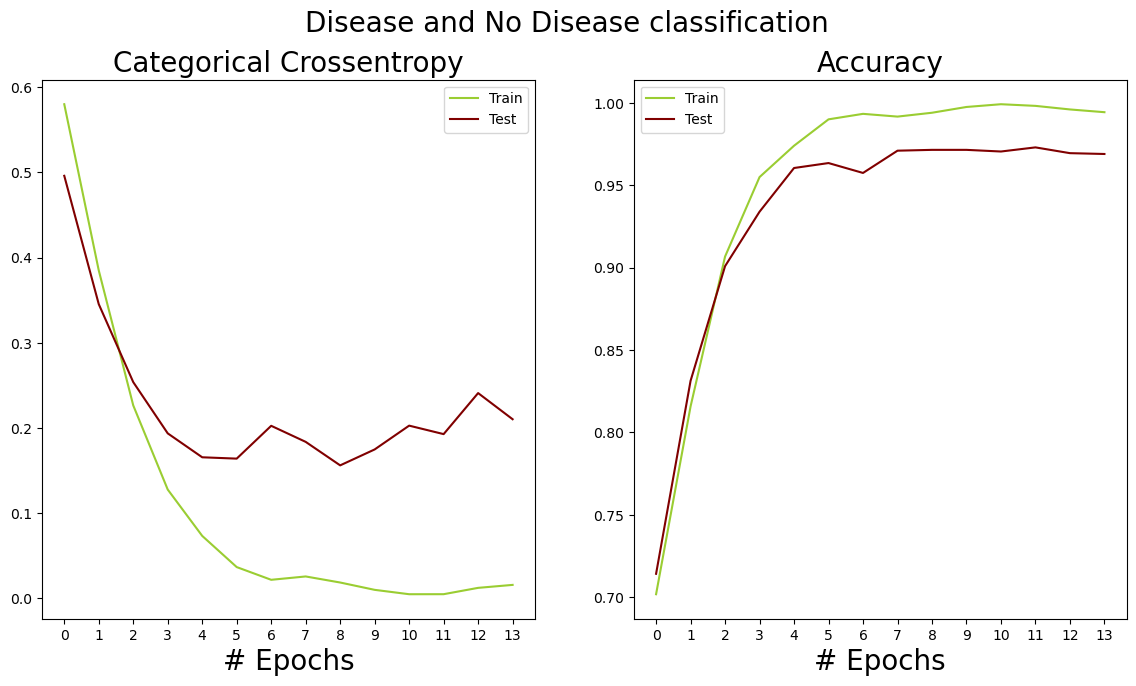

In [52]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Disease and No Disease classification')

In [44]:
def acc_conf_matrix(model, val_data=None, X=None, y=None, class_names_list = None, binary = False):
    '''
    '''
    # Generate Confusion Matrix
    predictions = np.array([])
    labels =  np.array([])
    if val_data == None:
        if binary:
            predictions = (model.predict(X, verbose = False) > 0.5).astype("int32")
            labels = y  
        else:
            predictions = np.concatenate([predictions, model.predict(X, verbose = False).argmax(axis=1)])
            labels = np.concatenate([labels, np.argmax(y, axis=-1)])

    else:
        for x, y in val_data:
            predictions = np.concatenate([predictions, model.predict(x, verbose = False).argmax(axis=1)])
            labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    cm = confusion_matrix(labels=labels, predictions=predictions).numpy()
    # Print Accuracy score
    acc = round(accuracy_score(labels, predictions), 4)
    print(f'Accuracy_score: {acc} \n') 
    # Plot the confusion matrix
    if class_names_list:
        fig, ax = plot_confusion_matrix(cm, class_names=class_names_list)    
    else:
        fig, ax = plot_confusion_matrix(cm, class_names=val_data.class_names)   

Accuracy_score: 0.9715 



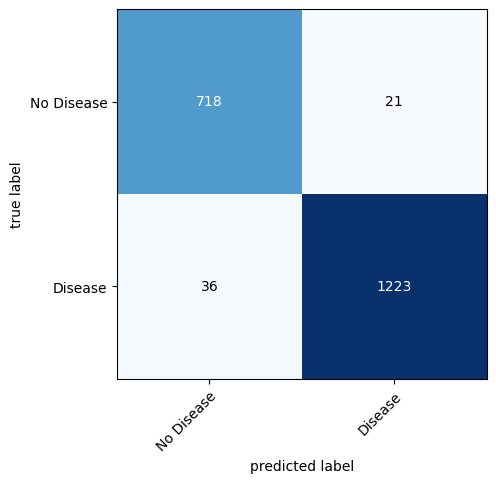

In [88]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.7077 



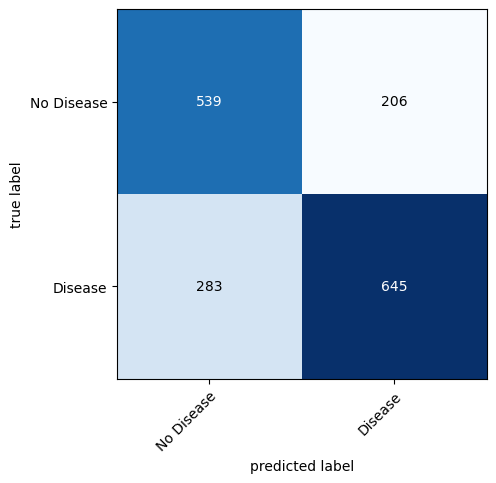

In [92]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

## Make Binary data Alzheimer's - Brain tumor
Combine datasets, ignoring No disease images and make binary data - Alzheimer's  - 0, Brain tumor - 1

In [38]:
X_train_al_bt, X_val_al_bt, y_train_al_bt, y_val_al_bt = combine_images_from_two_path_binary(al_path_train, bt_path_train, function = al_bt_load_img_from_dir_binary)

In [39]:
X_train_al_bt.shape, y_train_al_bt.shape

((2216, 240, 240, 1), (2216,))

In [40]:
X_test_al_bt, y_test_al_bt = combine_images_from_two_path_binary(al_path_test, bt_path_test, function = al_bt_load_img_from_dir_binary)

In [41]:
model_al_bt = Sequential()


model_al_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_al_bt.add(Conv2D(64, (3,3), activation='relu'))
model_al_bt.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model_al_bt.add(Conv2D(64, (3,3), activation='relu'))
model_al_bt.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model_al_bt.add(Flatten())
# Fully Connected
model_al_bt.add(Dense(64, activation = 'relu'))
model_al_bt.add(Dropout(0.2))
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=50, callbacks = [es])

Epoch 1/50
70/70 [==============================] - 55s 784ms/step - loss: 0.0524 - accuracy: 0.9865 - val_loss: 3.1870e-04 - val_accuracy: 1.0000
Epoch 2/50
70/70 [==============================] - 55s 786ms/step - loss: 1.6796e-04 - accuracy: 1.0000 - val_loss: 2.9464e-06 - val_accuracy: 1.0000
Epoch 3/50
70/70 [==============================] - 55s 785ms/step - loss: 2.9208e-05 - accuracy: 1.0000 - val_loss: 7.0638e-06 - val_accuracy: 1.0000
Epoch 4/50
70/70 [==============================] - 58s 824ms/step - loss: 1.2592e-05 - accuracy: 1.0000 - val_loss: 1.4692e-06 - val_accuracy: 1.0000
Epoch 5/50
70/70 [==============================] - 57s 813ms/step - loss: 1.0624e-05 - accuracy: 1.0000 - val_loss: 9.9282e-07 - val_accuracy: 1.0000
Epoch 6/50
70/70 [==============================] - 57s 810ms/step - loss: 5.9076e-06 - accuracy: 1.0000 - val_loss: 8.2904e-07 - val_accuracy: 1.0000
Epoch 7/50
70/70 [==============================] - 57s 809ms/step - loss: 1.0550e-05 - accuracy: 

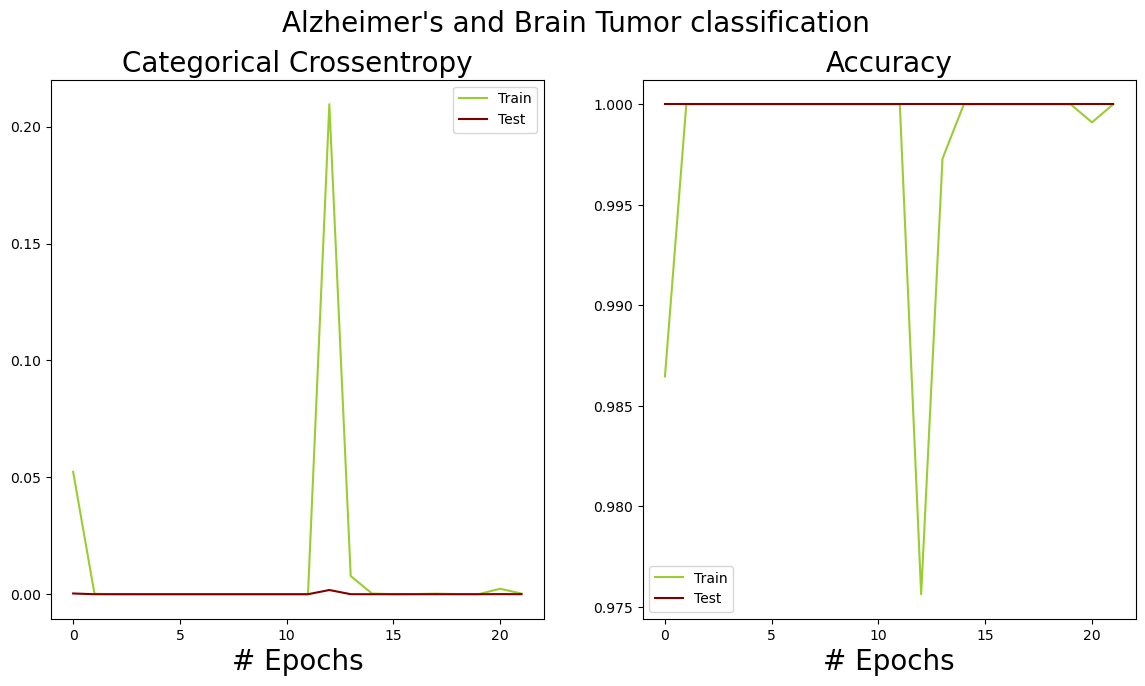

In [42]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 1.0 



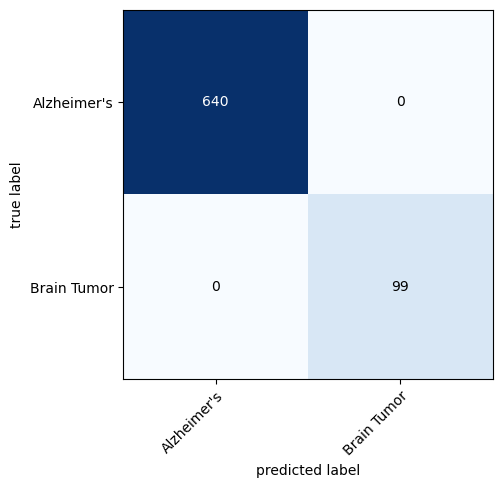

In [45]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 1.0 



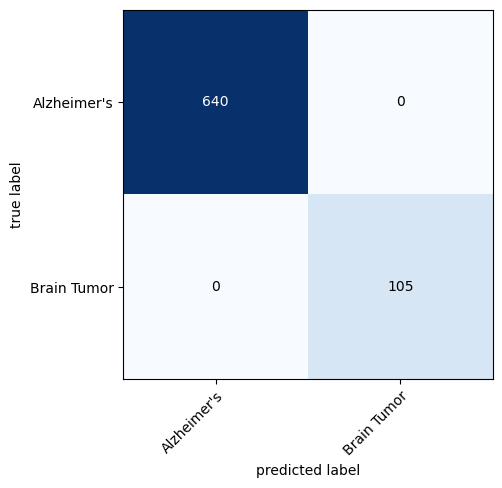

In [46]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

## Predict Sevetiry of Alzeimer's or Type of Brain Tumor

### Sevetiry of Alzeimer's

In [59]:
X_train_al, X_val_al, y_train_al, y_val_al = load_img_from_dir_cat(al_path_train)
X_train_al.shape, y_train_al.shape

((1920, 240, 240, 1), (1920, 3))

In [60]:
X_test_al, y_test_al = load_img_from_dir_cat(al_path_test)

In [78]:
model_al = Sequential()

model_al.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_al.add(Conv2D(64, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model_al.add(Conv2D(128, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Third Convolution
model_al.add(Conv2D(64, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model_al.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.2))
model_al.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_al.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=50, callbacks = [es])

Epoch 1/50
60/60 [==============================] - 70s 1s/step - loss: 1.0623 - accuracy: 0.6885 - val_loss: 0.8808 - val_accuracy: 0.7005
Epoch 2/50
60/60 [==============================] - 107s 2s/step - loss: 0.8290 - accuracy: 0.6995 - val_loss: 0.7745 - val_accuracy: 0.7005
Epoch 3/50
60/60 [==============================] - 113s 2s/step - loss: 0.7839 - accuracy: 0.6995 - val_loss: 0.7440 - val_accuracy: 0.7005
Epoch 4/50
60/60 [==============================] - 109s 2s/step - loss: 0.7428 - accuracy: 0.7052 - val_loss: 0.6784 - val_accuracy: 0.7301
Epoch 5/50
60/60 [==============================] - 109s 2s/step - loss: 0.7033 - accuracy: 0.7214 - val_loss: 0.6906 - val_accuracy: 0.7598
Epoch 6/50
60/60 [==============================] - 107s 2s/step - loss: 0.6682 - accuracy: 0.7365 - val_loss: 0.6589 - val_accuracy: 0.7473
Epoch 7/50
60/60 [==============================] - 109s 2s/step - loss: 0.5121 - accuracy: 0.8307 - val_loss: 0.4015 - val_accuracy: 0.8986
Epoch 8/50
60/

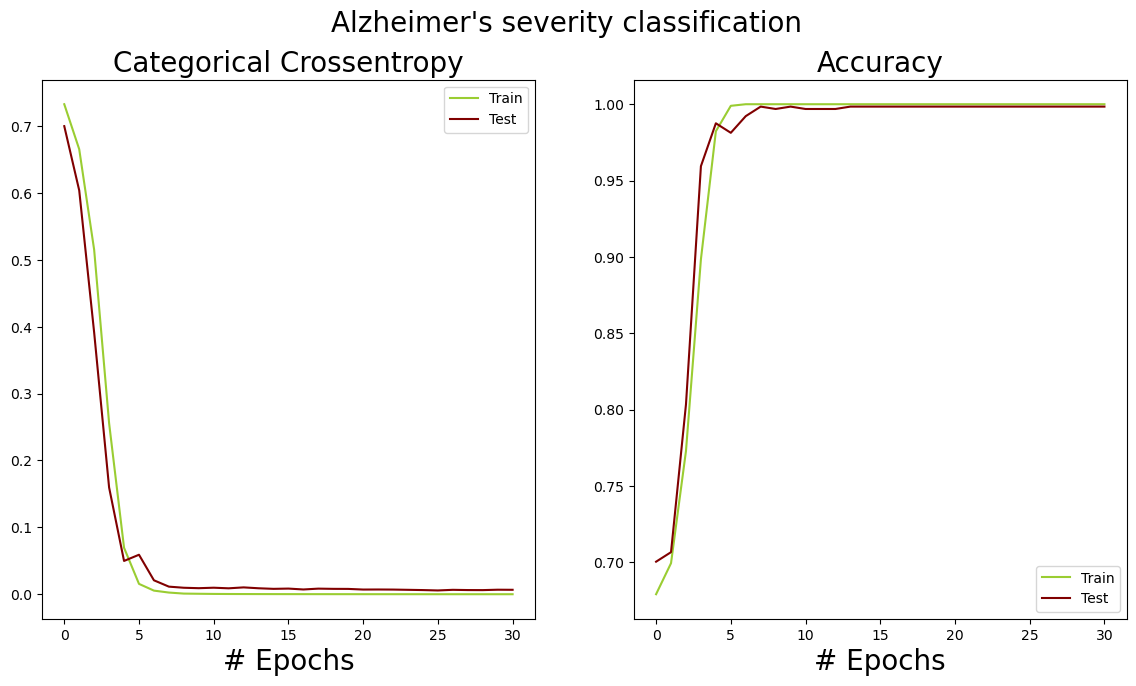

In [63]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9984 



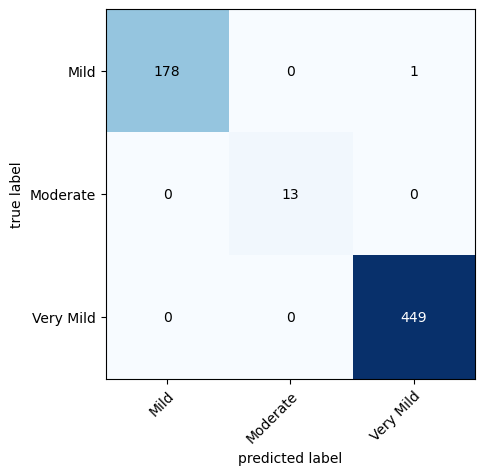

In [64]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7715 



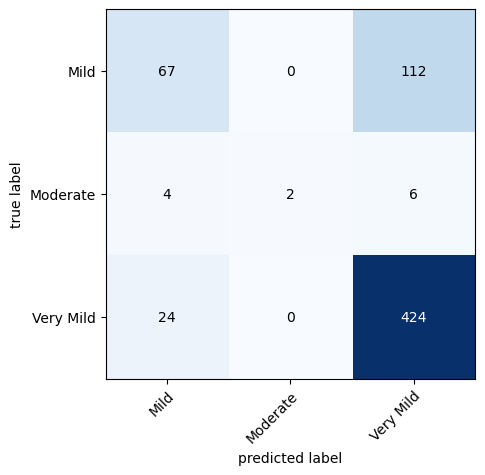

In [80]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7825 without dropouts and regularization

### Type of Brain Tumor

In [71]:
X_train_bt, X_val_bt, y_train_bt, y_val_bt = load_img_from_dir_cat(bt_path_train)
X_train_bt.shape, y_train_bt.shape

((1856, 240, 240, 1), (1856, 3))

In [72]:
X_test_bt, y_test_bt = load_img_from_dir_cat(bt_path_test)

In [74]:
model_bt = Sequential()
model_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model_bt.add(Conv2D(128, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model_bt.add(Conv2D(256, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model_bt.add(Conv2D(512, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model_bt.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.2))
model_bt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(3, activation='softmax'))
# Compile
model_bt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=50, callbacks = [es])

Epoch 1/50
58/58 [==============================] - 50s 845ms/step - loss: 1.9793 - accuracy: 0.5490 - val_loss: 1.2874 - val_accuracy: 0.5654
Epoch 2/50
58/58 [==============================] - 68s 1s/step - loss: 1.0647 - accuracy: 0.7101 - val_loss: 0.9748 - val_accuracy: 0.7044
Epoch 3/50
58/58 [==============================] - 78s 1s/step - loss: 0.8466 - accuracy: 0.7678 - val_loss: 0.9635 - val_accuracy: 0.7044
Epoch 4/50
58/58 [==============================] - 76s 1s/step - loss: 0.7498 - accuracy: 0.7985 - val_loss: 0.9242 - val_accuracy: 0.6850
Epoch 5/50
58/58 [==============================] - 76s 1s/step - loss: 0.6782 - accuracy: 0.8077 - val_loss: 0.5690 - val_accuracy: 0.8691
Epoch 6/50
58/58 [==============================] - 76s 1s/step - loss: 0.5858 - accuracy: 0.8567 - val_loss: 0.6177 - val_accuracy: 0.8595
Epoch 7/50
58/58 [==============================] - 76s 1s/step - loss: 0.5250 - accuracy: 0.8793 - val_loss: 0.5012 - val_accuracy: 0.8869
Epoch 8/50
58/58 

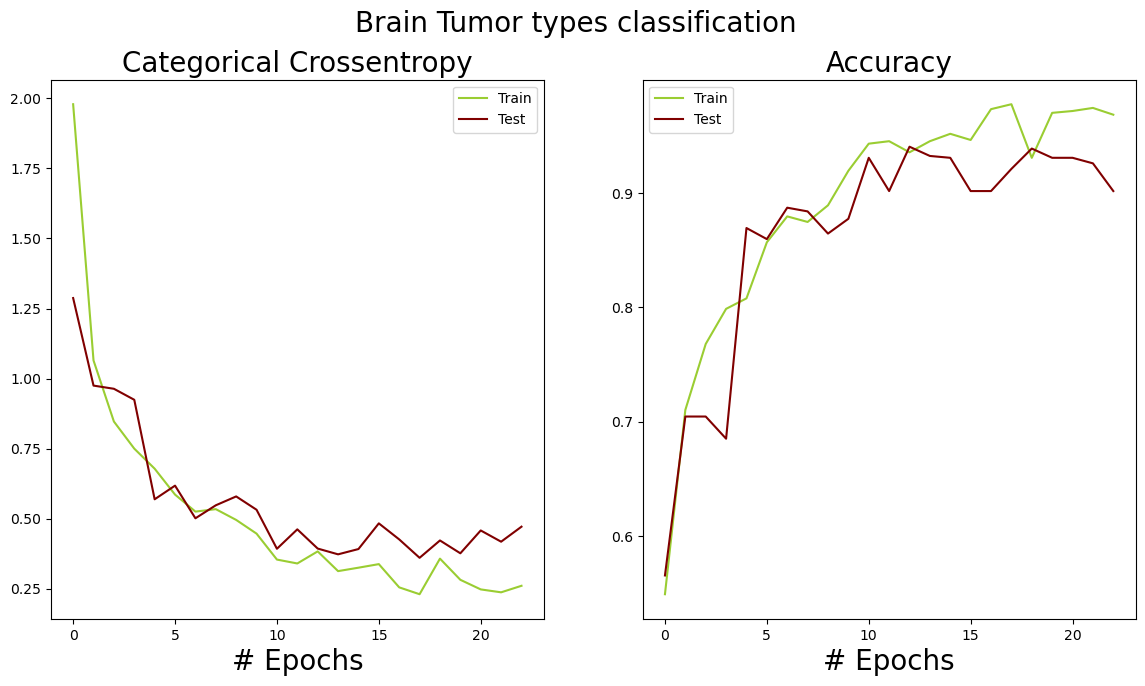

In [75]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9208 



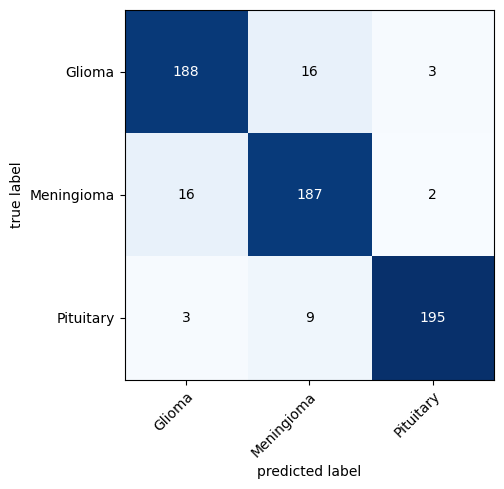

In [76]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.6159 



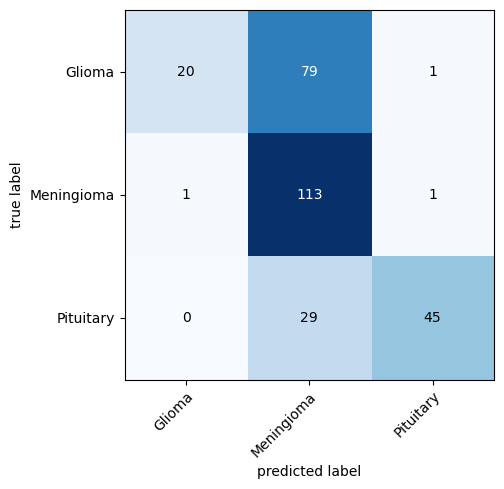

In [77]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [101]:
model_bt = Sequential()
model_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model_bt.add(Conv2D(128, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model_bt.add(Conv2D(256, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model_bt.add(Conv2D(512, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model_bt.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.2))
model_bt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(128, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(3, activation='softmax'))
# Compile
model_bt.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=50, callbacks=[es, reduce_lr])

Epoch 1/50
58/58 [==============================] - 99s 2s/step - loss: 2.1433 - accuracy: 0.5377 - val_loss: 1.4341 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 2/50
58/58 [==============================] - 116s 2s/step - loss: 1.2558 - accuracy: 0.6923 - val_loss: 1.0853 - val_accuracy: 0.7415 - lr: 1.0000e-04
Epoch 3/50
58/58 [==============================] - 119s 2s/step - loss: 1.0134 - accuracy: 0.7430 - val_loss: 0.9446 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 4/50
58/58 [==============================] - 118s 2s/step - loss: 0.8900 - accuracy: 0.7909 - val_loss: 0.8145 - val_accuracy: 0.8449 - lr: 1.0000e-04
Epoch 5/50
58/58 [==============================] - 118s 2s/step - loss: 0.7753 - accuracy: 0.8276 - val_loss: 0.7542 - val_accuracy: 0.8514 - lr: 1.0000e-04
Epoch 6/50
58/58 [==============================] - 116s 2s/step - loss: 0.7180 - accuracy: 0.8470 - val_loss: 0.9064 - val_accuracy: 0.7496 - lr: 1.0000e-04
Epoch 7/50
58/58 [==============================] - 1

Accuracy_score: 0.6471 



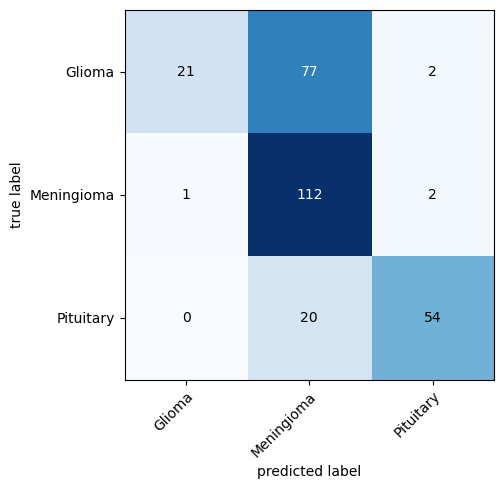

In [102]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

## Best so far

In [94]:
from keras.optimizers import Adam

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)


from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [95]:
model_bt = Sequential()
model_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model_bt.add(Conv2D(128, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model_bt.add(Conv2D(256, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model_bt.add(Conv2D(512, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model_bt.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.4))
model_bt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.4))
model_bt.add(Dense(128, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.4))
model_bt.add(Dense(3, activation='softmax'))
# Compile
model_bt.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=25, callbacks=[es, reduce_lr])

Epoch 1/25
58/58 [==============================] - 49s 839ms/step - loss: 1.9177 - accuracy: 0.5070 - val_loss: 1.2051 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 2/25
58/58 [==============================] - 47s 803ms/step - loss: 1.0782 - accuracy: 0.6730 - val_loss: 1.0823 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 3/25
58/58 [==============================] - 50s 864ms/step - loss: 0.9329 - accuracy: 0.7139 - val_loss: 0.7857 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 4/25
58/58 [==============================] - 73s 1s/step - loss: 0.8294 - accuracy: 0.7473 - val_loss: 0.8494 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 5/25
58/58 [==============================] - 77s 1s/step - loss: 0.8106 - accuracy: 0.7392 - val_loss: 0.7409 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 6/25
58/58 [==============================] - 103s 2s/step - loss: 0.7394 - accuracy: 0.7834 - val_loss: 0.7420 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 7/25
58/58 [==============================] - 101s 2s/step - loss:

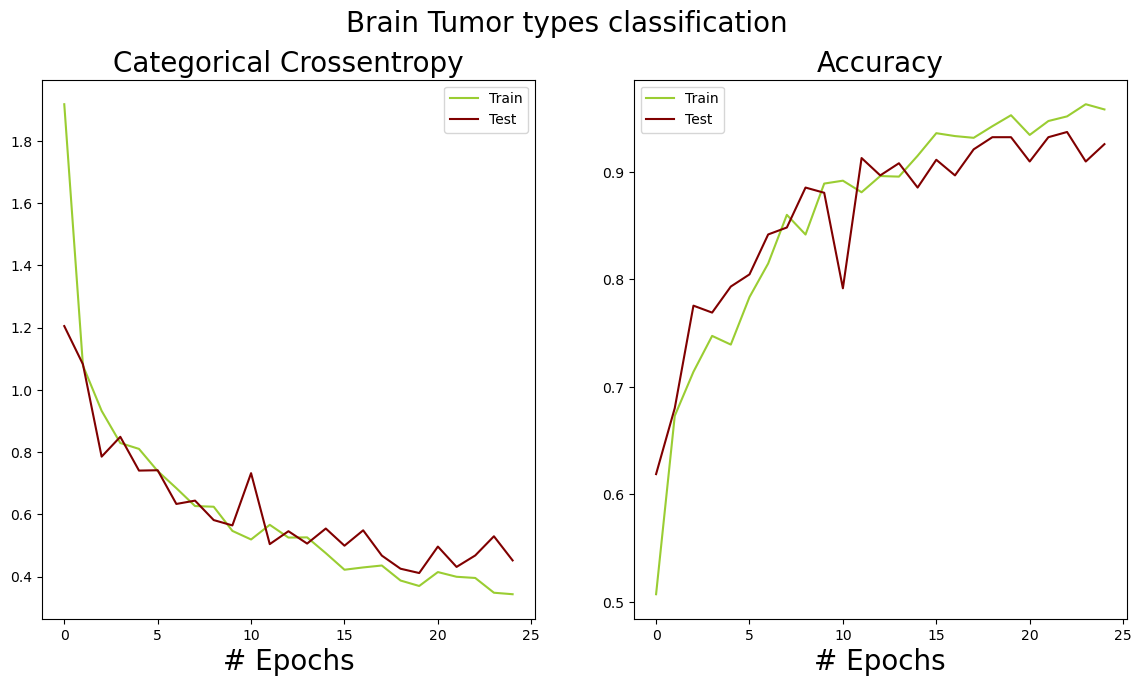

In [97]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9321 



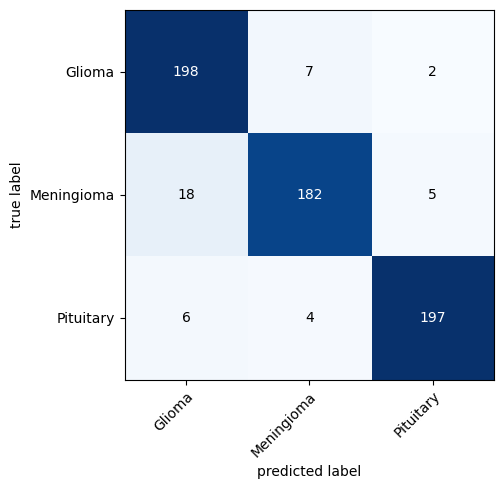

In [98]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.6782 



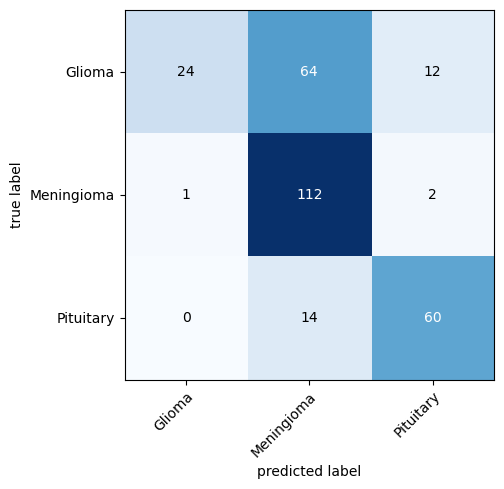

In [96]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

## Combine all to classify a single input image